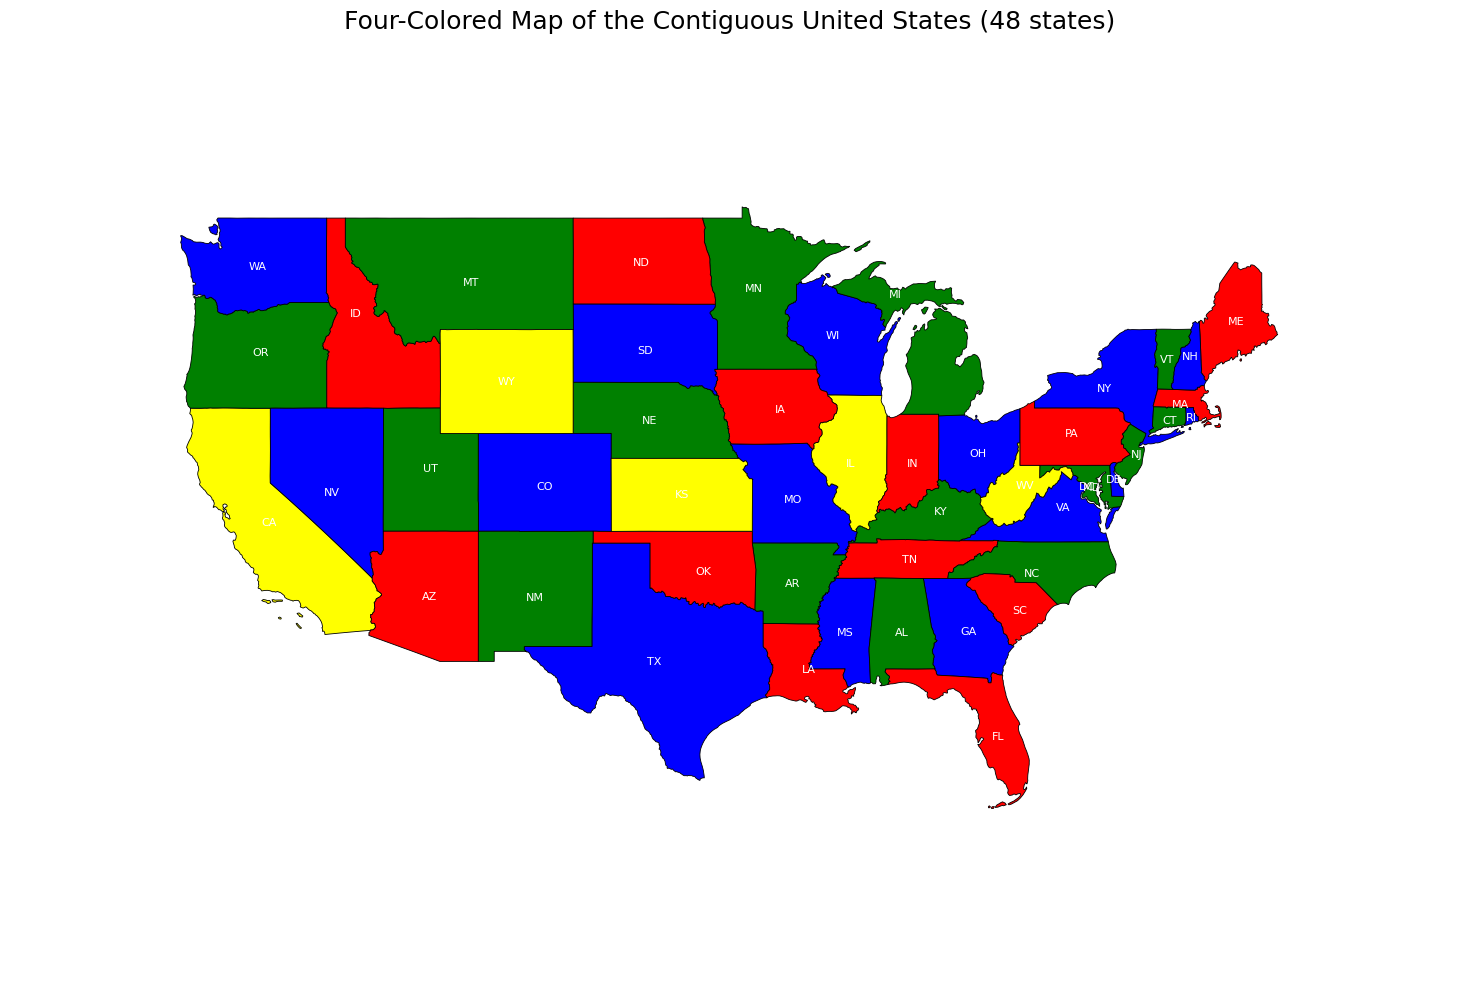

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

# ===== Load shapefile from the specified path =====
shp_path = r"C:\Users\fewku\Downloads\cb_2023_us_state_20m\cb_2023_us_state_20m.shp"
try:
    states = gpd.read_file(shp_path)
except Exception as e:
    raise FileNotFoundError(f"Shapefile not found at path: {shp_path}") from e

# ===== Keep only the 48 contiguous states =====
abbr_col = "STUSPS"
states = states[~states[abbr_col].isin(["AK","HI","PR"])].copy()

# Change projection to meters for better geometry calculations
states = states.to_crs(3857).reset_index(drop=True)

# ===== 4-Coloring (as before) =====
from collections import defaultdict
adj = defaultdict(set)
sindex = states.sindex
for i, g1 in enumerate(states.geometry):
    for j in sindex.intersection(g1.bounds):
        if i >= j:
            continue
        g2 = states.geometry[j]
        if g1.touches(g2):
            inter = g1.intersection(g2)
            if getattr(inter, "length", 0) > 0:
                s1 = states.at[i, abbr_col]
                s2 = states.at[j, abbr_col]
                adj[s1].add(s2)
                adj[s2].add(s1)

for code in states[abbr_col]:
    adj.setdefault(code, set())

palette = ["#FF0000", "#0000FF", "#008000", "#FFFF00"]
order = sorted(adj.keys(), key=lambda k: len(adj[k]), reverse=True)
coloring = {}

def can_use(state, c):
    return all(coloring.get(n) != c for n in adj[state])

def backtrack(idx=0):
    if idx == len(order):
        return True
    s = order[idx]
    for c in range(4):
        if can_use(s, c):
            coloring[s] = c
            if backtrack(idx + 1):
                return True
            del coloring[s]
    return False

assert backtrack(), "Cannot color with 4 colors"

states["__cidx"] = states[abbr_col].map(coloring)
states["__color"] = states["__cidx"].map(lambda i: palette[i] if i is not None else "#cccccc")

# ===== Draw the map (zoomed to the 48 contiguous states) =====
fig, ax = plt.subplots(figsize=(16, 10))  # Enlarge the image
states.plot(ax=ax, color=states["__color"], edgecolor="black", linewidth=0.6)

for _, row in states.iterrows():
    x, y = row.geometry.representative_point().coords[0]
    ax.text(x, y, row[abbr_col], ha="center", va="center", fontsize=8, color="white")

ax.set_title("Four-Colored Map of the Contiguous United States (48 states)", fontsize=18)

# Set zoom limits to only the mainland US
minx, miny, maxx, maxy = states.total_bounds
ax.set_xlim(minx-1e6, maxx+1e6)
ax.set_ylim(miny-1e6, maxy+1e6)

ax.axis("off")
plt.tight_layout()
plt.show()